# INSTALL DL2

In [ ]:
!pip install d2l

     |████████████████████████████████| 82 kB 587 kB/s 
     |████████████████████████████████| 11.2 MB 28.5 MB/s 
     |████████████████████████████████| 9.9 MB 25.3 MB/s 
     |████████████████████████████████| 61 kB 6.8 MB/s 
     |████████████████████████████████| 900 kB 35.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you h

In [ ]:
!pip install matplotlib==3.0.2

     |████████████████████████████████| 12.9 MB 51 kB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
d2l 0.17.5 requires matplotlib==3.5.1, but you have matplotlib 3.0.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import numpy as np

# Try load VGG16

# LOAD DATA BIRD 224 by 224

### packages

In [ ]:
import numpy as np
import os
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler
import cv2
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
import torchvision.models as models
import torch
from torch import nn
import time

import torch.nn.functional as F

### CODE

In [ ]:
TEST_PATH = '/content/drive/MyDrive/CS Work/projet CS/dataset/final_test_no_bg/'
TRAIN_PATH = '/content/drive/MyDrive/CS Work/projet CS/dataset/data_augm_train_final_no_bg/'

In [ ]:


classes = os.listdir(TEST_PATH)
classes.remove('.DS_Store')
print("Total Classes: ",len(classes))

train_count = 0
test_count = 0
for _class in classes:
    train_count += len(os.listdir(TRAIN_PATH + _class))
    test_count += len(os.listdir(TEST_PATH + _class))

print("Total train images: ",train_count)
print("Total test images: ",test_count)


Total Classes:  10
Total train images:  2614
Total test images:  109


In [ ]:
# get paths (with. name of each image)
train_imgs = []
test_imgs = []

for _class in classes:
    
    for img in os.listdir(TRAIN_PATH + _class):
        if img != '.DS_Store':
          train_imgs.append(TRAIN_PATH + _class + "/" + img)
        
    for img in os.listdir(TEST_PATH + _class):
      if img != '.DS_Store':
        test_imgs.append(TEST_PATH + _class + "/" + img)

class_to_int = {classes[i] : i for i in range(len(classes))}

In [ ]:
### Loading Classification Dataset - FOR METHOD 2: For multi-class data, by inheriting Dataset class

def get_transform():
    return T.Compose([T.ToTensor()])

class BirdDataset(Dataset):
    
    def __init__(self, imgs_list, class_to_int, transforms = None):
        
        super().__init__()
        self.imgs_list = imgs_list
        self.class_to_int = class_to_int
        self.transforms = transforms
        
        
    def __getitem__(self, index):
        transform = T.Resize(size = (224,224))
        image_path = self.imgs_list[index]
        
        #Reading image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        
        #Retriving class label
        label = image_path.split("/")[-2]
        #print("label : " + str(label))
        label = self.class_to_int[label]
        
        #Applying transforms on image
        if self.transforms:
            image = self.transforms(image)
        
        image = transform(image)
        return image, label
        
        
        
    def __len__(self):
        return len(self.imgs_list)

In [ ]:
# Method 2: Using Dataset Class
train_dataset = BirdDataset(train_imgs, class_to_int, get_transform())
test_dataset = BirdDataset(test_imgs, class_to_int, get_transform())

#Data Loader  -  using Sampler (YT Video)
train_random_sampler = RandomSampler(train_dataset)
test_random_sampler = RandomSampler(test_dataset)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
## HYPER PARAM ##


# best val for the accuracy
best_val_acc = 0
#init perf decrease
counter_perf_decrease = 0
# nb perf decrease to stop training
nb_perf_decrease_stop = 2
# drop out rates
dr_rate = 0.5

In [ ]:
#Shuffle Argument is mutually exclusive with Sampler!
train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    sampler = train_random_sampler,
    num_workers = 4,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 32,
    sampler = test_random_sampler,
    num_workers = 4,
)


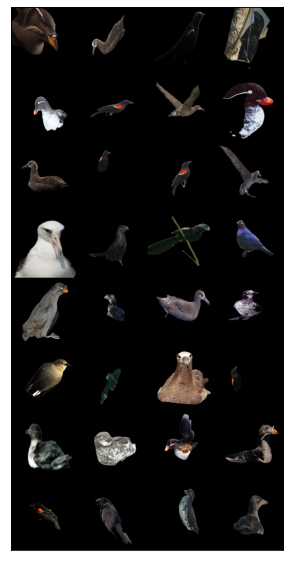

In [ ]:
# Visualize one training batch
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [ ]:
### Define model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
# NOTE: cross_entropy loss takes unnormalized op (logits), then function itself applies softmax and calculates loss, so no need to include softmax here
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(25088, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(dr_rate),
    nn.Linear(2048, 524, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(dr_rate),
    nn.Linear(524, len(classes))
)


In [ ]:
dr_rate

0.5

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# only updated params of classifier
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
  param.requires_grad = True

In [ ]:
### Get device

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 20

In [ ]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

In [ ]:
### Training Code



for epoch in range(epochs):
    
    start = time.time()
    
    #Epoch Loss & Accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []
    _iter = 1
    
    #Val Loss & Accuracy
    val_epoch_loss = []
    val_epoch_accuracy = []
    
    # Training
    for images, labels in train_data_loader:
        
        # train of model
        model.train()
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Reset Grads
        optimizer.zero_grad()
        
        #Forward ->
        preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss & Backward, Update Weights (Step)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        #Append loss & acc
        loss_value = loss.item()
        train_epoch_loss.append(loss_value)
        train_epoch_accuracy.append(acc)
        
        if _iter % 500 == 0:
            print("> Iteration {} < ".format(_iter))
            print("Iter Loss = {}".format(round(loss_value, 4)))
            print("Iter Accuracy = {} % \n".format(acc))
        
        _iter += 1
    
    #Validation
    for images, labels in test_data_loader:
        # eval
        model.eval()
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward ->
        preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss
        loss = criterion(preds, labels)
        
        #Append loss & acc
        loss_value = loss.item()
        val_epoch_loss.append(loss_value)
        val_epoch_accuracy.append(acc)
    
    
    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    
    end = time.time()
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    if val_epoch_accuracy > best_val_acc :
      print("save model for epoch : " + str(epoch))
      best_val_acc = val_epoch_accuracy
      torch.save(model, "/content/drive/MyDrive/CS Work/projet CS/dataset/VGG16_nobg.pt")

      # re init perf decrease
      counter_perf_decrease = 0 
    else :
      counter_perf_decrease += 1

    # stop training if perf decreasing
    if counter_perf_decrease == nb_perf_decrease_stop:
      print("Stop training because of perf decrease")


    
    #Print Epoch Statistics
    print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
    print("Train Loss = {}".format(round(train_epoch_loss, 4)))
    print("Train Accuracy = {} % \n".format(train_epoch_accuracy))
    print("Val Loss = {}".format(round(val_epoch_loss, 4)))
    print("Val Accuracy = {} % \n".format(val_epoch_accuracy))
    
    

save model for epoch : 0
** Epoch 0 ** - Epoch Time 130
Train Loss = 2.2345
Train Accuracy = 22.243393902439024 % 

Val Loss = 2.1348
Val Accuracy = 29.5673 % 

save model for epoch : 1
** Epoch 1 ** - Epoch Time 37
Train Loss = 1.9789
Train Accuracy = 38.59247926829268 % 

Val Loss = 1.8205
Val Accuracy = 40.8053 % 

save model for epoch : 2
** Epoch 2 ** - Epoch Time 37
Train Loss = 1.6534
Train Accuracy = 51.72764268292683 % 

Val Loss = 1.6144
Val Accuracy = 50.60095 % 

save model for epoch : 3
** Epoch 3 ** - Epoch Time 37
Train Loss = 1.3764
Train Accuracy = 60.37855731707317 % 

Val Loss = 1.395
Val Accuracy = 54.8678 % 

save model for epoch : 4
** Epoch 4 ** - Epoch Time 37
Train Loss = 1.1592
Train Accuracy = 68.6483743902439 % 

Val Loss = 1.2571
Val Accuracy = 65.324525 % 

** Epoch 5 ** - Epoch Time 37
Train Loss = 0.9912
Train Accuracy = 73.66615853658537 % 

Val Loss = 1.1751
Val Accuracy = 60.33655 % 

Stop training because of perf decrease
** Epoch 6 ** - Epoch Time 3

batch size 16: -> 0.74...
batch size 32: -> 0.76


moins bonne perf en changeant le drop out rate